In [2]:
import numpy as np
import cupy as cp
from scipy import integrate as integ
from scipy import signal as signal
import sympy as sp
import matplotlib
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
import seaborn as sns
import ipywidgets
from tqdm import tqdm
###
from turing_model import TuringModel as tm
from numba import jit

In [3]:
@jit(nopython=True)
def slow(var, t):
    # fill var
    N_a = var[0]
    N_b = var[1]
    A_a = var[2]
    A_b = var[3]
    H_1a = var[4]
    H_1b = var[5]
    H_2a = var[6]
    H_2b = var[7]
    d_H1a = var[8]
    d_H2a = var[9]
    d_H1b = var[10]
    d_H2b = var[11]
    H1_loss = var[12]
    H2_loss = var[13]

    # growth rate of autotrophs
    r_a = (r_max * N_a) / (N_h + N_a)
    r_b = (r_max * N_b) / (N_h + N_b)

    # growth rate of competitors
    g_1a = (a_1 * A_a) / (1 + a_1 * h * A_a)
    g_1b = (a_1 * A_b) / (1 + a_1 * h * A_b)
    g_2a = (a_2 * A_a) / (1 + a_2 * h * A_a)
    g_2b = (a_2 * A_b) / (1 + a_2 * h * A_b)

    # inflection points
    x_01 = D / (a_1 * (e - h * D))
    x_02 = D / (a_2 * (e - h * D))
    
    # dispersal rates of competitors
    d_H1a = d_Hmax1 / (1 + np.exp(k_1 * (A_a - x_01)))
    d_H1b = d_Hmax1 / (1 + np.exp(k_1 * (A_b - x_01)))
    d_H2a = d_Hmax2 / (1 + np.exp(k_2 * (A_a - x_02)))
    d_H2b = d_Hmax2 / (1 + np.exp(k_2 * (A_b - x_02)))

    # change of nutrients
    dN_a = D * (S - N_a) - r_a * A_a + d_N * (N_b - N_a)
    dN_b = D * (S - N_b) - r_b * A_b + d_N * (N_a - N_b)

    # change of autotrophs
    dA_a = r_a * A_a - ((g_1a * H_1a) + (g_2a * H_2a)) - D * A_a + d_A * (A_b - A_a)
    dA_b = r_b * A_b - ((g_1b * H_1b) + (g_2b * H_2b)) - D * A_b + d_A * (A_a - A_b)

    # change of competitors
    dH_1a = e * g_1a * H_1a - D * H_1a - d_H1a * H_1a + d_H1b * H_1b
    dH_1b = e * g_1b * H_1b - D * H_1b - d_H1b * H_1b + d_H1a * H_1a
    dH_2a = e * g_2a * H_2a - D * H_2a - d_H2a * H_2a + d_H2b * H_2b
    dH_2b = e * g_2b * H_2b - D * H_2b - d_H2b * H_2b + d_H2a * H_2a

    H1_loss = d_H1a-(d_H1a * dH_1a)/(1 + np.exp(k_1 * (A_a - x_01)))
    H2_loss = d_H2a-(d_H2a * dH_2a)/(1 + np.exp(k_2 * (A_a - x_02)))

    return(dN_a, dN_b, dA_a, dA_b, dH_1a, dH_1b, dH_2a, dH_2b, d_H1a, d_H2a, d_H1b, d_H2b, H1_loss, H2_loss)

In [4]:
# var
var = []

# set parameters
S = 4.8 # Nutrient supply concentration
D = 0.3 # Dilution rate
N_h = 1.5 # half saturation constant for nutrient uptake
r_max = 0.7 # growth rate of autotroph
h = 0.53 # handling time
e = 0.33 # conversion efficiency of competitor
d_N = 1 # Dispersal rate of nutrients 
d_A = 0.001 # dispersal rate of autotrophs

# competitiveness 
a_1 = 1 # attack rate of competitor 1 
a_2 = 1 # attack rate of competitor 2 

# adaptability
k_1 = 0 # dispersal adaptability of competitor 1 
k_2 = 2 # dispersal adaptability of competitor 2 
        # 0 = random dispersal, 2 = adaptive dispersal

# dispersal speed 
d_Hmax1 = 0.0001 # maximal dispersal rates of competitor 1  
d_Hmax2 = 0.0001 # maximal dispersal rates of competitor 2  

In [5]:
t_end = 1000#0 #4000  # 100000
number_steps = 100#00 #2000  # 25000
t = np.linspace(0, t_end, number_steps)
# dispersal adaptability
k_1 = 5
k_2 = 0
k_1_range = np.geomspace(0.0001, 10, 100)
k_2_range = np.geomspace(0.0001, 10, 100)
# maximum dispersal rate
d_Hmax1 = 10**-2
d_Hmax2 = 10**-2
d_Hmax1_range = np.logspace(-3, 1, 25)
d_Hmax2_range = d_Hmax1_range

# var = [N_a, N_b, A_a, A_b, H_1a, H_1b, H_2a, H_2b]
var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0, 0, 0]
var = []

H1x_extr = []
H1y_extr = []
H2x_extr = []
H2y_extr = []
H1_extr = []
H2_extr = []
num_extr = 20

In [33]:
# Save results
# results = np.zeros((len(d_Hmax1_range),len(d_Hmax2_range)))
density_H1x = cp.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H2x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
density_H2y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
mode_H1 = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
mode_H2 = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H2x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
checkOsc_H2y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H2x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H2y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
autodensity_Ax = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
autodensity_Ay = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
autodensityOsc_Ax = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
autodensityOsc_Ay = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
H1xmax = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
H2xmax = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
H1xmin = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
H2xmin = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
total_H1 = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
total_H2 = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
invasion = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
# save initial values in an array
initials = np.array(var0)

In [ ]:
# Integrating over two variable parameters
# change for new method with equation wrapper

var = []

i = 0
j = 0

for d_Hmax2 in tqdm(d_Hmax2_range):
    j = 0
    for d_Hmax1 in d_Hmax1_range:
        var = integ.odeint(slow, var0, t)

        # results[i,j] = ...
        density_H1x[i, j] = var[-1, 4]
        density_H1y[i, j] = var[-1, 5]
        density_H2x[i, j] = var[-1, 6]
        density_H2y[i, j] = var[-1, 7]

        checkOsc_H1x[i, j] = np.var(var[-200:-1, 4])
        checkOsc_H1y[i, j] = np.var(var[-200:-1, 5])
        checkOsc_H2x[i, j] = np.var(var[-200:-1, 6])
        checkOsc_H2y[i, j] = np.var(var[-200:-1, 7])

        meandensity_H1x[i, j] = np.mean(var[-200:-1, 4])
        meandensity_H1y[i, j] = np.mean(var[-200:-1, 5])
        meandensity_H2x[i, j] = np.mean(var[-200:-1, 6])
        meandensity_H2y[i, j] = np.mean(var[-200:-1, 7])

        autodensity_Ax[i, j] = np.mean(var[-200:-1, 2])
        autodensity_Ay[i, j] = np.mean(var[-200:-1, 3])

        autodensityOsc_Ax[i, j] = np.var(var[-200:-1, 2])
        autodensityOsc_Ay[i, j] = np.var(var[-200:-1, 3])

        H1xmax[i, j] = max(var[-200:-1, 4])
        H2xmax[i, j] = max(var[-200:-1, 6])

        j += 1
    i += 1

In [37]:
# Integrating over two variable parameters
# change for new method with equation wrapper

var = []

i = 0
j = 0

meandensity_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))
meandensity_H1y = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))

for d_Hmax2 in tqdm(d_Hmax2_range):
    j = 0
    for d_Hmax1 in d_Hmax1_range:
        var = integ.odeint(slow, var0, t)
        
        # results[i,j] = ...
        meandensity_H1x[i, j] = np.mean(var[-200:-1, 4])
        meandensity_H1y[i, j] = np.mean(var[-200:-1, 5])

        j += 1
    i += 1

  0%|          | 0/25 [00:00<?, ?it/s]

[[2.00000000e+00 2.50000000e+00 2.50000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.25019203e+00 2.74934761e+00 2.97371970e+00 ... 5.05050505e-03
  6.42670441e-05 5.02832677e-03]
 [2.90283775e+00 3.05590926e+00 1.36400613e+00 ... 1.01010101e-02
  2.19499043e-03 1.00594003e-02]
 ...
 [1.42177349e+00 2.09348887e+00 5.10565138e+00 ... 4.89898990e-01
  4.84842062e-01 4.89909635e-01]
 [1.42267449e+00 1.91614105e+00 4.28735720e+00 ... 4.94949495e-01
  4.84842065e-01 4.94926407e-01]
 [2.39094797e+00 2.18447486e+00 9.98400625e-01 ... 5.00000000e-01
  4.87503926e-01 4.99950212e-01]]
[[2.00000000e+00 2.50000000e+00 2.50000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.25019203e+00 2.74934761e+00 2.97371970e+00 ... 5.05050505e-03
  6.42670441e-05 5.02832677e-03]
 [2.90283775e+00 3.05590926e+00 1.36400613e+00 ... 1.01010101e-02
  2.19499043e-03 1.00594003e-02]
 ...
 [1.42177349e+00 2.09348887e+00 5.10565138e+00 ... 4.89898990e-01
  4.84842062e-01 4.89909635e-01]

  4%|▍         | 1/25 [00:40<16:08, 40.35s/it]

[[2.00000000e+00 2.50000000e+00 2.50000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.25019203e+00 2.74934761e+00 2.97371970e+00 ... 5.05050505e-03
  6.42670441e-05 5.02832677e-03]
 [2.90283775e+00 3.05590926e+00 1.36400613e+00 ... 1.01010101e-02
  2.19499043e-03 1.00594003e-02]
 ...
 [1.42177349e+00 2.09348887e+00 5.10565138e+00 ... 4.89898990e-01
  4.84842062e-01 4.89909635e-01]
 [1.42267449e+00 1.91614105e+00 4.28735720e+00 ... 4.94949495e-01
  4.84842065e-01 4.94926407e-01]
 [2.39094797e+00 2.18447486e+00 9.98400625e-01 ... 5.00000000e-01
  4.87503926e-01 4.99950212e-01]]
[[2.00000000e+00 2.50000000e+00 2.50000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.25019203e+00 2.74934761e+00 2.97371970e+00 ... 5.05050505e-03
  6.42670441e-05 5.02832677e-03]
 [2.90283775e+00 3.05590926e+00 1.36400613e+00 ... 1.01010101e-02
  2.19499043e-03 1.00594003e-02]
 ...
 [1.42177349e+00 2.09348887e+00 5.10565138e+00 ... 4.89898990e-01
  4.84842062e-01 4.89909635e-01]

  4%|▍         | 1/25 [00:45<18:11, 45.47s/it]


KeyboardInterrupt: 

In [35]:
meandensity_H1x

array([[0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343],
       [0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343],
       [0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.08727343, 0.08727343,
        0.08727343, 0.08727343, 0.08727343, 0.

In [ ]:
# Set up parameters and arrays
t_end = 1000
number_steps = 100
t = np.linspace(0, t_end, number_steps)

k_1_range = np.geomspace(0.0001, 10, 100)
k_2_range = np.geomspace(0.0001, 10, 100)
d_Hmax1_range = np.logspace(-3, 1, 25)
d_Hmax2_range = d_Hmax1_range

# Initialize arrays to store results
density_H1x = np.zeros((len(d_Hmax2_range), len(d_Hmax1_range)))

# Initial conditions
var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0, 0, 0]


for i, d_Hmax2 in enumerate(tqdm(d_Hmax2_range)):
    for j, d_Hmax1 in enumerate(d_Hmax1_range):
        var0 = [2, 2.5, 2.5, 2, 0.08, 0.4, 0.08, 0.4, 0, 0, 0, 0, 0, 0]
        var = integ.odeint(slow, var0, t)
        meandensity_H1x[i, j] = np.mean(var[-200:-1, 4])


<Axes: >

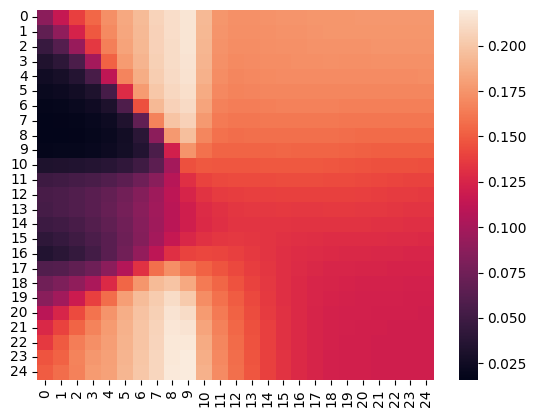

In [100]:
# Random dispersal scenario
# Heatmap: Iterating over dHmax1 and dHmax2 for k1 = k2 = 0.


sns.heatmap(meandensity_H1x)

In [21]:
import time

5.583812713623047


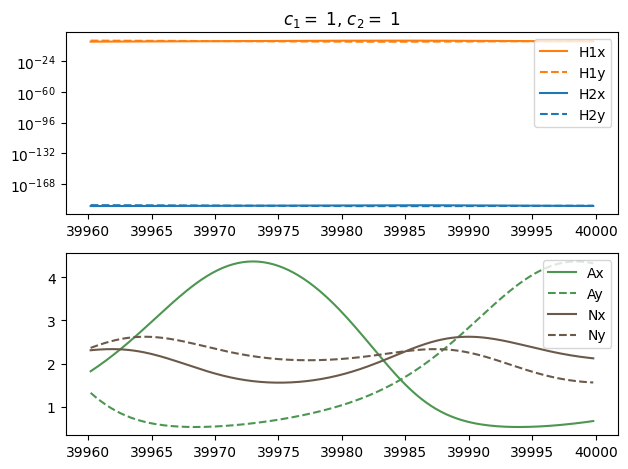

In [26]:
start_time = time.time()
t_end = 40000
number_steps = 200000
t = np.linspace(0,t_end,number_steps)
c_1 = 10**0
c_2 = 10**0
d_Hmax1 = 10**-2
d_Hmax2 = 10**-3
var0 = [2, 2.5, 2.5, 2, 0.2, 0.3, 0.2, 0.3, 0, 0, 0, 0, 0, 0]
var = []
var = integ.odeint(slow, var0, t)
plt.subplot2grid((2,1),(0,0))
plt.plot(t[-200:-1], var[-200:-1, 4], "-", color="#FF7F0E", label="H1x")
plt.plot(t[-200:-1], var[-200:-1, 5], "--", color="#FF7F0E", label="H1y")
plt.plot(t[-200:-1], var[-200:-1, 6], "-", color="#1F77B4", label="H2x")
plt.plot(t[-200:-1], var[-200:-1, 7], "--", color="#1F77B4", label="H2y")
plt.yscale("log")
plt.legend(loc="upper right")
plt.title("$c_1 = $ " + str(c_1) + ", $c_2 = $ " + str(c_2))

plt.subplot2grid((2,1),(1,0))
plt.plot(t[-200:-1], var[-200:-1, 2], "-", color="#4D9651", label="Ax")
plt.plot(t[-200:-1], var[-200:-1, 3], "--", color="#4D9651", label="Ay")
plt.plot(t[-200:-1], var[-200:-1, 0], "-", color="#6B5949", label="Nx")
plt.plot(t[-200:-1], var[-200:-1:, 1], "--", color="#6B5949", label="Ny")
plt.legend(loc="upper right")
plt.tight_layout()
time_taken = time.time() - start_time
print(time_taken)

In [6]:
meandensity_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))

# Define the integration function without the jit decorator
def integrate_slow(var0, t):
    return integ.odeint(slow, var0, t)

#@jit(nopython=True)
def calculate_mean_density(d_Hmax2_range, d_Hmax1_range, meandensity_H1x):
    for i in range(len(d_Hmax2_range)):
        for j in range(len(d_Hmax1_range)):
            var = integrate_slow(var0, t)
            meandensity_H1x[i, j] = np.mean(var[-200:-1, 4])


In [7]:
# Call the function with the arrays and matrix
calculate_mean_density(d_Hmax2_range, d_Hmax1_range, meandensity_H1x)

In [8]:
meandensity_H1x

array([[0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304],
       [0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304],
       [0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.14550304, 0.14550304,
        0.14550304, 0.14550304, 0.14550304, 0.

In [12]:
meandensity_H1x = np.zeros(((len(d_Hmax2_range)),(len(d_Hmax2_range))))

for i, d_Hmax2 in enumerate(tqdm(d_Hmax2_range)):
    for j, d_Hmax1 in enumerate(d_Hmax1_range):
        var0_copy = var0.copy()
        var = integ.odeint(slow, var0_copy, t)
        result = np.mean(var[-200:-1, 4])
        
        # Debugging: Print intermediate values for verification
        print(f"i: {i}, j: {j}, result: {result}")
        
        # Store the result in the array
        meandensity_H1x[i, j] = result



  0%|          | 0/25 [00:00<?, ?it/s]

i: 0, j: 0, result: 0.14550304194434904
i: 0, j: 1, result: 0.14550304194434904
i: 0, j: 2, result: 0.14550304194434904
i: 0, j: 3, result: 0.14550304194434904
i: 0, j: 4, result: 0.14550304194434904
i: 0, j: 5, result: 0.14550304194434904
i: 0, j: 6, result: 0.14550304194434904
i: 0, j: 7, result: 0.14550304194434904
i: 0, j: 8, result: 0.14550304194434904
i: 0, j: 9, result: 0.14550304194434904
i: 0, j: 10, result: 0.14550304194434904
i: 0, j: 11, result: 0.14550304194434904
i: 0, j: 12, result: 0.14550304194434904
i: 0, j: 13, result: 0.14550304194434904
i: 0, j: 14, result: 0.14550304194434904
i: 0, j: 15, result: 0.14550304194434904


  4%|▍         | 1/25 [00:00<00:09,  2.63it/s]

i: 0, j: 16, result: 0.14550304194434904
i: 0, j: 17, result: 0.14550304194434904
i: 0, j: 18, result: 0.14550304194434904
i: 0, j: 19, result: 0.14550304194434904
i: 0, j: 20, result: 0.14550304194434904
i: 0, j: 21, result: 0.14550304194434904
i: 0, j: 22, result: 0.14550304194434904
i: 0, j: 23, result: 0.14550304194434904
i: 0, j: 24, result: 0.14550304194434904
i: 1, j: 0, result: 0.14550304194434904
i: 1, j: 1, result: 0.14550304194434904
i: 1, j: 2, result: 0.14550304194434904
i: 1, j: 3, result: 0.14550304194434904
i: 1, j: 4, result: 0.14550304194434904
i: 1, j: 5, result: 0.14550304194434904
i: 1, j: 6, result: 0.14550304194434904
i: 1, j: 7, result: 0.14550304194434904
i: 1, j: 8, result: 0.14550304194434904
i: 1, j: 9, result: 0.14550304194434904
i: 1, j: 10, result: 0.14550304194434904


  8%|▊         | 2/25 [00:00<00:08,  2.61it/s]

i: 1, j: 11, result: 0.14550304194434904
i: 1, j: 12, result: 0.14550304194434904
i: 1, j: 13, result: 0.14550304194434904
i: 1, j: 14, result: 0.14550304194434904
i: 1, j: 15, result: 0.14550304194434904
i: 1, j: 16, result: 0.14550304194434904
i: 1, j: 17, result: 0.14550304194434904
i: 1, j: 18, result: 0.14550304194434904
i: 1, j: 19, result: 0.14550304194434904
i: 1, j: 20, result: 0.14550304194434904
i: 1, j: 21, result: 0.14550304194434904
i: 1, j: 22, result: 0.14550304194434904
i: 1, j: 23, result: 0.14550304194434904
i: 1, j: 24, result: 0.14550304194434904
i: 2, j: 0, result: 0.14550304194434904
i: 2, j: 1, result: 0.14550304194434904
i: 2, j: 2, result: 0.14550304194434904
i: 2, j: 3, result: 0.14550304194434904
i: 2, j: 4, result: 0.14550304194434904
i: 2, j: 5, result: 0.14550304194434904
i: 2, j: 6, result: 0.14550304194434904
i: 2, j: 7, result: 0.14550304194434904


 12%|█▏        | 3/25 [00:01<00:08,  2.60it/s]

i: 2, j: 8, result: 0.14550304194434904
i: 2, j: 9, result: 0.14550304194434904
i: 2, j: 10, result: 0.14550304194434904
i: 2, j: 11, result: 0.14550304194434904
i: 2, j: 12, result: 0.14550304194434904
i: 2, j: 13, result: 0.14550304194434904
i: 2, j: 14, result: 0.14550304194434904
i: 2, j: 15, result: 0.14550304194434904
i: 2, j: 16, result: 0.14550304194434904
i: 2, j: 17, result: 0.14550304194434904
i: 2, j: 18, result: 0.14550304194434904
i: 2, j: 19, result: 0.14550304194434904
i: 2, j: 20, result: 0.14550304194434904
i: 2, j: 21, result: 0.14550304194434904
i: 2, j: 22, result: 0.14550304194434904
i: 2, j: 23, result: 0.14550304194434904
i: 2, j: 24, result: 0.14550304194434904
i: 3, j: 0, result: 0.14550304194434904
i: 3, j: 1, result: 0.14550304194434904
i: 3, j: 2, result: 0.14550304194434904
i: 3, j: 3, result: 0.14550304194434904
i: 3, j: 4, result: 0.14550304194434904
i: 3, j: 5, result: 0.14550304194434904
i: 3, j: 6, result: 0.14550304194434904
i: 3, j: 7, result: 0.145

 16%|█▌        | 4/25 [00:01<00:08,  2.62it/s]

i: 3, j: 10, result: 0.14550304194434904
i: 3, j: 11, result: 0.14550304194434904
i: 3, j: 12, result: 0.14550304194434904
i: 3, j: 13, result: 0.14550304194434904
i: 3, j: 14, result: 0.14550304194434904
i: 3, j: 15, result: 0.14550304194434904
i: 3, j: 16, result: 0.14550304194434904
i: 3, j: 17, result: 0.14550304194434904
i: 3, j: 18, result: 0.14550304194434904
i: 3, j: 19, result: 0.14550304194434904
i: 3, j: 20, result: 0.14550304194434904
i: 3, j: 21, result: 0.14550304194434904
i: 3, j: 22, result: 0.14550304194434904
i: 3, j: 23, result: 0.14550304194434904
i: 3, j: 24, result: 0.14550304194434904
i: 4, j: 0, result: 0.14550304194434904
i: 4, j: 1, result: 0.14550304194434904
i: 4, j: 2, result: 0.14550304194434904
i: 4, j: 3, result: 0.14550304194434904
i: 4, j: 4, result: 0.14550304194434904
i: 4, j: 5, result: 0.14550304194434904
i: 4, j: 6, result: 0.14550304194434904
i: 4, j: 7, result: 0.14550304194434904
i: 4, j: 8, result: 0.14550304194434904


 20%|██        | 5/25 [00:01<00:07,  2.60it/s]

i: 4, j: 9, result: 0.14550304194434904
i: 4, j: 10, result: 0.14550304194434904
i: 4, j: 11, result: 0.14550304194434904
i: 4, j: 12, result: 0.14550304194434904
i: 4, j: 13, result: 0.14550304194434904
i: 4, j: 14, result: 0.14550304194434904
i: 4, j: 15, result: 0.14550304194434904
i: 4, j: 16, result: 0.14550304194434904
i: 4, j: 17, result: 0.14550304194434904
i: 4, j: 18, result: 0.14550304194434904
i: 4, j: 19, result: 0.14550304194434904
i: 4, j: 20, result: 0.14550304194434904
i: 4, j: 21, result: 0.14550304194434904
i: 4, j: 22, result: 0.14550304194434904
i: 4, j: 23, result: 0.14550304194434904
i: 4, j: 24, result: 0.14550304194434904
i: 5, j: 0, result: 0.14550304194434904
i: 5, j: 1, result: 0.14550304194434904
i: 5, j: 2, result: 0.14550304194434904
i: 5, j: 3, result: 0.14550304194434904
i: 5, j: 4, result: 0.14550304194434904
i: 5, j: 5, result: 0.14550304194434904
i: 5, j: 6, result: 0.14550304194434904
i: 5, j: 7, result: 0.14550304194434904
i: 5, j: 8, result: 0.145

 24%|██▍       | 6/25 [00:02<00:07,  2.60it/s]

i: 5, j: 10, result: 0.14550304194434904
i: 5, j: 11, result: 0.14550304194434904
i: 5, j: 12, result: 0.14550304194434904
i: 5, j: 13, result: 0.14550304194434904
i: 5, j: 14, result: 0.14550304194434904
i: 5, j: 15, result: 0.14550304194434904
i: 5, j: 16, result: 0.14550304194434904
i: 5, j: 17, result: 0.14550304194434904
i: 5, j: 18, result: 0.14550304194434904
i: 5, j: 19, result: 0.14550304194434904
i: 5, j: 20, result: 0.14550304194434904
i: 5, j: 21, result: 0.14550304194434904
i: 5, j: 22, result: 0.14550304194434904
i: 5, j: 23, result: 0.14550304194434904
i: 5, j: 24, result: 0.14550304194434904
i: 6, j: 0, result: 0.14550304194434904
i: 6, j: 1, result: 0.14550304194434904
i: 6, j: 2, result: 0.14550304194434904
i: 6, j: 3, result: 0.14550304194434904
i: 6, j: 4, result: 0.14550304194434904
i: 6, j: 5, result: 0.14550304194434904
i: 6, j: 6, result: 0.14550304194434904
i: 6, j: 7, result: 0.14550304194434904
i: 6, j: 8, result: 0.14550304194434904
i: 6, j: 9, result: 0.145

 28%|██▊       | 7/25 [00:02<00:06,  2.61it/s]

i: 6, j: 11, result: 0.14550304194434904
i: 6, j: 12, result: 0.14550304194434904
i: 6, j: 13, result: 0.14550304194434904
i: 6, j: 14, result: 0.14550304194434904
i: 6, j: 15, result: 0.14550304194434904
i: 6, j: 16, result: 0.14550304194434904
i: 6, j: 17, result: 0.14550304194434904
i: 6, j: 18, result: 0.14550304194434904
i: 6, j: 19, result: 0.14550304194434904
i: 6, j: 20, result: 0.14550304194434904
i: 6, j: 21, result: 0.14550304194434904
i: 6, j: 22, result: 0.14550304194434904
i: 6, j: 23, result: 0.14550304194434904
i: 6, j: 24, result: 0.14550304194434904
i: 7, j: 0, result: 0.14550304194434904
i: 7, j: 1, result: 0.14550304194434904
i: 7, j: 2, result: 0.14550304194434904
i: 7, j: 3, result: 0.14550304194434904
i: 7, j: 4, result: 0.14550304194434904
i: 7, j: 5, result: 0.14550304194434904
i: 7, j: 6, result: 0.14550304194434904
i: 7, j: 7, result: 0.14550304194434904
i: 7, j: 8, result: 0.14550304194434904


 32%|███▏      | 8/25 [00:03<00:06,  2.62it/s]

i: 7, j: 9, result: 0.14550304194434904
i: 7, j: 10, result: 0.14550304194434904
i: 7, j: 11, result: 0.14550304194434904
i: 7, j: 12, result: 0.14550304194434904
i: 7, j: 13, result: 0.14550304194434904
i: 7, j: 14, result: 0.14550304194434904
i: 7, j: 15, result: 0.14550304194434904
i: 7, j: 16, result: 0.14550304194434904
i: 7, j: 17, result: 0.14550304194434904
i: 7, j: 18, result: 0.14550304194434904
i: 7, j: 19, result: 0.14550304194434904
i: 7, j: 20, result: 0.14550304194434904
i: 7, j: 21, result: 0.14550304194434904
i: 7, j: 22, result: 0.14550304194434904
i: 7, j: 23, result: 0.14550304194434904
i: 7, j: 24, result: 0.14550304194434904
i: 8, j: 0, result: 0.14550304194434904
i: 8, j: 1, result: 0.14550304194434904
i: 8, j: 2, result: 0.14550304194434904
i: 8, j: 3, result: 0.14550304194434904
i: 8, j: 4, result: 0.14550304194434904
i: 8, j: 5, result: 0.14550304194434904
i: 8, j: 6, result: 0.14550304194434904
i: 8, j: 7, result: 0.14550304194434904
i: 8, j: 8, result: 0.145

 36%|███▌      | 9/25 [00:03<00:06,  2.58it/s]

i: 8, j: 9, result: 0.14550304194434904
i: 8, j: 10, result: 0.14550304194434904
i: 8, j: 11, result: 0.14550304194434904
i: 8, j: 12, result: 0.14550304194434904
i: 8, j: 13, result: 0.14550304194434904
i: 8, j: 14, result: 0.14550304194434904
i: 8, j: 15, result: 0.14550304194434904
i: 8, j: 16, result: 0.14550304194434904
i: 8, j: 17, result: 0.14550304194434904
i: 8, j: 18, result: 0.14550304194434904
i: 8, j: 19, result: 0.14550304194434904
i: 8, j: 20, result: 0.14550304194434904
i: 8, j: 21, result: 0.14550304194434904
i: 8, j: 22, result: 0.14550304194434904
i: 8, j: 23, result: 0.14550304194434904
i: 8, j: 24, result: 0.14550304194434904
i: 9, j: 0, result: 0.14550304194434904
i: 9, j: 1, result: 0.14550304194434904
i: 9, j: 2, result: 0.14550304194434904
i: 9, j: 3, result: 0.14550304194434904
i: 9, j: 4, result: 0.14550304194434904
i: 9, j: 5, result: 0.14550304194434904
i: 9, j: 6, result: 0.14550304194434904
i: 9, j: 7, result: 0.14550304194434904
i: 9, j: 8, result: 0.145

 40%|████      | 10/25 [00:03<00:05,  2.57it/s]

i: 9, j: 11, result: 0.14550304194434904
i: 9, j: 12, result: 0.14550304194434904
i: 9, j: 13, result: 0.14550304194434904
i: 9, j: 14, result: 0.14550304194434904
i: 9, j: 15, result: 0.14550304194434904
i: 9, j: 16, result: 0.14550304194434904
i: 9, j: 17, result: 0.14550304194434904
i: 9, j: 18, result: 0.14550304194434904
i: 9, j: 19, result: 0.14550304194434904
i: 9, j: 20, result: 0.14550304194434904
i: 9, j: 21, result: 0.14550304194434904
i: 9, j: 22, result: 0.14550304194434904
i: 9, j: 23, result: 0.14550304194434904
i: 9, j: 24, result: 0.14550304194434904
i: 10, j: 0, result: 0.14550304194434904
i: 10, j: 1, result: 0.14550304194434904
i: 10, j: 2, result: 0.14550304194434904
i: 10, j: 3, result: 0.14550304194434904
i: 10, j: 4, result: 0.14550304194434904
i: 10, j: 5, result: 0.14550304194434904
i: 10, j: 6, result: 0.14550304194434904
i: 10, j: 7, result: 0.14550304194434904
i: 10, j: 8, result: 0.14550304194434904
i: 10, j: 9, result: 0.14550304194434904
i: 10, j: 10, re

 44%|████▍     | 11/25 [00:04<00:05,  2.57it/s]

i: 10, j: 12, result: 0.14550304194434904
i: 10, j: 13, result: 0.14550304194434904
i: 10, j: 14, result: 0.14550304194434904
i: 10, j: 15, result: 0.14550304194434904
i: 10, j: 16, result: 0.14550304194434904
i: 10, j: 17, result: 0.14550304194434904
i: 10, j: 18, result: 0.14550304194434904
i: 10, j: 19, result: 0.14550304194434904
i: 10, j: 20, result: 0.14550304194434904
i: 10, j: 21, result: 0.14550304194434904
i: 10, j: 22, result: 0.14550304194434904
i: 10, j: 23, result: 0.14550304194434904
i: 10, j: 24, result: 0.14550304194434904
i: 11, j: 0, result: 0.14550304194434904
i: 11, j: 1, result: 0.14550304194434904
i: 11, j: 2, result: 0.14550304194434904
i: 11, j: 3, result: 0.14550304194434904
i: 11, j: 4, result: 0.14550304194434904
i: 11, j: 5, result: 0.14550304194434904
i: 11, j: 6, result: 0.14550304194434904
i: 11, j: 7, result: 0.14550304194434904


 48%|████▊     | 12/25 [00:04<00:05,  2.57it/s]

i: 11, j: 8, result: 0.14550304194434904
i: 11, j: 9, result: 0.14550304194434904
i: 11, j: 10, result: 0.14550304194434904
i: 11, j: 11, result: 0.14550304194434904
i: 11, j: 12, result: 0.14550304194434904
i: 11, j: 13, result: 0.14550304194434904
i: 11, j: 14, result: 0.14550304194434904
i: 11, j: 15, result: 0.14550304194434904
i: 11, j: 16, result: 0.14550304194434904
i: 11, j: 17, result: 0.14550304194434904
i: 11, j: 18, result: 0.14550304194434904
i: 11, j: 19, result: 0.14550304194434904
i: 11, j: 20, result: 0.14550304194434904
i: 11, j: 21, result: 0.14550304194434904
i: 11, j: 22, result: 0.14550304194434904
i: 11, j: 23, result: 0.14550304194434904
i: 11, j: 24, result: 0.14550304194434904
i: 12, j: 0, result: 0.14550304194434904
i: 12, j: 1, result: 0.14550304194434904
i: 12, j: 2, result: 0.14550304194434904
i: 12, j: 3, result: 0.14550304194434904
i: 12, j: 4, result: 0.14550304194434904
i: 12, j: 5, result: 0.14550304194434904
i: 12, j: 6, result: 0.14550304194434904
i

 52%|█████▏    | 13/25 [00:05<00:04,  2.57it/s]

i: 12, j: 9, result: 0.14550304194434904
i: 12, j: 10, result: 0.14550304194434904
i: 12, j: 11, result: 0.14550304194434904
i: 12, j: 12, result: 0.14550304194434904
i: 12, j: 13, result: 0.14550304194434904
i: 12, j: 14, result: 0.14550304194434904
i: 12, j: 15, result: 0.14550304194434904
i: 12, j: 16, result: 0.14550304194434904
i: 12, j: 17, result: 0.14550304194434904
i: 12, j: 18, result: 0.14550304194434904
i: 12, j: 19, result: 0.14550304194434904
i: 12, j: 20, result: 0.14550304194434904
i: 12, j: 21, result: 0.14550304194434904
i: 12, j: 22, result: 0.14550304194434904
i: 12, j: 23, result: 0.14550304194434904
i: 12, j: 24, result: 0.14550304194434904
i: 13, j: 0, result: 0.14550304194434904
i: 13, j: 1, result: 0.14550304194434904
i: 13, j: 2, result: 0.14550304194434904
i: 13, j: 3, result: 0.14550304194434904
i: 13, j: 4, result: 0.14550304194434904
i: 13, j: 5, result: 0.14550304194434904
i: 13, j: 6, result: 0.14550304194434904
i: 13, j: 7, result: 0.14550304194434904
i

 56%|█████▌    | 14/25 [00:05<00:04,  2.58it/s]

i: 13, j: 15, result: 0.14550304194434904
i: 13, j: 16, result: 0.14550304194434904
i: 13, j: 17, result: 0.14550304194434904
i: 13, j: 18, result: 0.14550304194434904
i: 13, j: 19, result: 0.14550304194434904
i: 13, j: 20, result: 0.14550304194434904
i: 13, j: 21, result: 0.14550304194434904
i: 13, j: 22, result: 0.14550304194434904
i: 13, j: 23, result: 0.14550304194434904
i: 13, j: 24, result: 0.14550304194434904
i: 14, j: 0, result: 0.14550304194434904
i: 14, j: 1, result: 0.14550304194434904
i: 14, j: 2, result: 0.14550304194434904
i: 14, j: 3, result: 0.14550304194434904
i: 14, j: 4, result: 0.14550304194434904
i: 14, j: 5, result: 0.14550304194434904
i: 14, j: 6, result: 0.14550304194434904
i: 14, j: 7, result: 0.14550304194434904
i: 14, j: 8, result: 0.14550304194434904
i: 14, j: 9, result: 0.14550304194434904
i: 14, j: 10, result: 0.14550304194434904
i: 14, j: 11, result: 0.14550304194434904
i: 14, j: 12, result: 0.14550304194434904


 60%|██████    | 15/25 [00:05<00:03,  2.59it/s]

i: 14, j: 13, result: 0.14550304194434904
i: 14, j: 14, result: 0.14550304194434904
i: 14, j: 15, result: 0.14550304194434904
i: 14, j: 16, result: 0.14550304194434904
i: 14, j: 17, result: 0.14550304194434904
i: 14, j: 18, result: 0.14550304194434904
i: 14, j: 19, result: 0.14550304194434904
i: 14, j: 20, result: 0.14550304194434904
i: 14, j: 21, result: 0.14550304194434904
i: 14, j: 22, result: 0.14550304194434904
i: 14, j: 23, result: 0.14550304194434904
i: 14, j: 24, result: 0.14550304194434904
i: 15, j: 0, result: 0.14550304194434904
i: 15, j: 1, result: 0.14550304194434904
i: 15, j: 2, result: 0.14550304194434904
i: 15, j: 3, result: 0.14550304194434904
i: 15, j: 4, result: 0.14550304194434904
i: 15, j: 5, result: 0.14550304194434904
i: 15, j: 6, result: 0.14550304194434904
i: 15, j: 7, result: 0.14550304194434904
i: 15, j: 8, result: 0.14550304194434904
i: 15, j: 9, result: 0.14550304194434904
i: 15, j: 10, result: 0.14550304194434904
i: 15, j: 11, result: 0.14550304194434904
i:

 64%|██████▍   | 16/25 [00:06<00:03,  2.60it/s]

i: 15, j: 15, result: 0.14550304194434904
i: 15, j: 16, result: 0.14550304194434904
i: 15, j: 17, result: 0.14550304194434904
i: 15, j: 18, result: 0.14550304194434904
i: 15, j: 19, result: 0.14550304194434904
i: 15, j: 20, result: 0.14550304194434904
i: 15, j: 21, result: 0.14550304194434904
i: 15, j: 22, result: 0.14550304194434904
i: 15, j: 23, result: 0.14550304194434904
i: 15, j: 24, result: 0.14550304194434904
i: 16, j: 0, result: 0.14550304194434904
i: 16, j: 1, result: 0.14550304194434904
i: 16, j: 2, result: 0.14550304194434904
i: 16, j: 3, result: 0.14550304194434904
i: 16, j: 4, result: 0.14550304194434904
i: 16, j: 5, result: 0.14550304194434904
i: 16, j: 6, result: 0.14550304194434904
i: 16, j: 7, result: 0.14550304194434904
i: 16, j: 8, result: 0.14550304194434904
i: 16, j: 9, result: 0.14550304194434904
i: 16, j: 10, result: 0.14550304194434904


 68%|██████▊   | 17/25 [00:06<00:03,  2.56it/s]

i: 16, j: 11, result: 0.14550304194434904
i: 16, j: 12, result: 0.14550304194434904
i: 16, j: 13, result: 0.14550304194434904
i: 16, j: 14, result: 0.14550304194434904
i: 16, j: 15, result: 0.14550304194434904
i: 16, j: 16, result: 0.14550304194434904
i: 16, j: 17, result: 0.14550304194434904
i: 16, j: 18, result: 0.14550304194434904
i: 16, j: 19, result: 0.14550304194434904
i: 16, j: 20, result: 0.14550304194434904
i: 16, j: 21, result: 0.14550304194434904
i: 16, j: 22, result: 0.14550304194434904
i: 16, j: 23, result: 0.14550304194434904
i: 16, j: 24, result: 0.14550304194434904
i: 17, j: 0, result: 0.14550304194434904
i: 17, j: 1, result: 0.14550304194434904
i: 17, j: 2, result: 0.14550304194434904
i: 17, j: 3, result: 0.14550304194434904
i: 17, j: 4, result: 0.14550304194434904
i: 17, j: 5, result: 0.14550304194434904
i: 17, j: 6, result: 0.14550304194434904
i: 17, j: 7, result: 0.14550304194434904
i: 17, j: 8, result: 0.14550304194434904


 72%|███████▏  | 18/25 [00:06<00:02,  2.55it/s]

i: 17, j: 9, result: 0.14550304194434904
i: 17, j: 10, result: 0.14550304194434904
i: 17, j: 11, result: 0.14550304194434904
i: 17, j: 12, result: 0.14550304194434904
i: 17, j: 13, result: 0.14550304194434904
i: 17, j: 14, result: 0.14550304194434904
i: 17, j: 15, result: 0.14550304194434904
i: 17, j: 16, result: 0.14550304194434904
i: 17, j: 17, result: 0.14550304194434904
i: 17, j: 18, result: 0.14550304194434904
i: 17, j: 19, result: 0.14550304194434904
i: 17, j: 20, result: 0.14550304194434904
i: 17, j: 21, result: 0.14550304194434904
i: 17, j: 22, result: 0.14550304194434904
i: 17, j: 23, result: 0.14550304194434904
i: 17, j: 24, result: 0.14550304194434904
i: 18, j: 0, result: 0.14550304194434904
i: 18, j: 1, result: 0.14550304194434904
i: 18, j: 2, result: 0.14550304194434904
i: 18, j: 3, result: 0.14550304194434904
i: 18, j: 4, result: 0.14550304194434904
i: 18, j: 5, result: 0.14550304194434904
i: 18, j: 6, result: 0.14550304194434904
i: 18, j: 7, result: 0.14550304194434904
i

 76%|███████▌  | 19/25 [00:07<00:02,  2.57it/s]

i: 18, j: 11, result: 0.14550304194434904
i: 18, j: 12, result: 0.14550304194434904
i: 18, j: 13, result: 0.14550304194434904
i: 18, j: 14, result: 0.14550304194434904
i: 18, j: 15, result: 0.14550304194434904
i: 18, j: 16, result: 0.14550304194434904
i: 18, j: 17, result: 0.14550304194434904
i: 18, j: 18, result: 0.14550304194434904
i: 18, j: 19, result: 0.14550304194434904
i: 18, j: 20, result: 0.14550304194434904
i: 18, j: 21, result: 0.14550304194434904
i: 18, j: 22, result: 0.14550304194434904
i: 18, j: 23, result: 0.14550304194434904
i: 18, j: 24, result: 0.14550304194434904
i: 19, j: 0, result: 0.14550304194434904
i: 19, j: 1, result: 0.14550304194434904
i: 19, j: 2, result: 0.14550304194434904
i: 19, j: 3, result: 0.14550304194434904
i: 19, j: 4, result: 0.14550304194434904
i: 19, j: 5, result: 0.14550304194434904
i: 19, j: 6, result: 0.14550304194434904
i: 19, j: 7, result: 0.14550304194434904
i: 19, j: 8, result: 0.14550304194434904
i: 19, j: 9, result: 0.14550304194434904
i:

 80%|████████  | 20/25 [00:07<00:01,  2.58it/s]

i: 19, j: 11, result: 0.14550304194434904
i: 19, j: 12, result: 0.14550304194434904
i: 19, j: 13, result: 0.14550304194434904
i: 19, j: 14, result: 0.14550304194434904
i: 19, j: 15, result: 0.14550304194434904
i: 19, j: 16, result: 0.14550304194434904
i: 19, j: 17, result: 0.14550304194434904
i: 19, j: 18, result: 0.14550304194434904
i: 19, j: 19, result: 0.14550304194434904
i: 19, j: 20, result: 0.14550304194434904
i: 19, j: 21, result: 0.14550304194434904
i: 19, j: 22, result: 0.14550304194434904
i: 19, j: 23, result: 0.14550304194434904
i: 19, j: 24, result: 0.14550304194434904
i: 20, j: 0, result: 0.14550304194434904
i: 20, j: 1, result: 0.14550304194434904
i: 20, j: 2, result: 0.14550304194434904
i: 20, j: 3, result: 0.14550304194434904
i: 20, j: 4, result: 0.14550304194434904
i: 20, j: 5, result: 0.14550304194434904
i: 20, j: 6, result: 0.14550304194434904
i: 20, j: 7, result: 0.14550304194434904


 84%|████████▍ | 21/25 [00:08<00:01,  2.58it/s]

i: 20, j: 8, result: 0.14550304194434904
i: 20, j: 9, result: 0.14550304194434904
i: 20, j: 10, result: 0.14550304194434904
i: 20, j: 11, result: 0.14550304194434904
i: 20, j: 12, result: 0.14550304194434904
i: 20, j: 13, result: 0.14550304194434904
i: 20, j: 14, result: 0.14550304194434904
i: 20, j: 15, result: 0.14550304194434904
i: 20, j: 16, result: 0.14550304194434904
i: 20, j: 17, result: 0.14550304194434904
i: 20, j: 18, result: 0.14550304194434904
i: 20, j: 19, result: 0.14550304194434904
i: 20, j: 20, result: 0.14550304194434904
i: 20, j: 21, result: 0.14550304194434904
i: 20, j: 22, result: 0.14550304194434904
i: 20, j: 23, result: 0.14550304194434904
i: 20, j: 24, result: 0.14550304194434904
i: 21, j: 0, result: 0.14550304194434904
i: 21, j: 1, result: 0.14550304194434904
i: 21, j: 2, result: 0.14550304194434904
i: 21, j: 3, result: 0.14550304194434904
i: 21, j: 4, result: 0.14550304194434904
i: 21, j: 5, result: 0.14550304194434904


 88%|████████▊ | 22/25 [00:08<00:01,  2.58it/s]

i: 21, j: 6, result: 0.14550304194434904
i: 21, j: 7, result: 0.14550304194434904
i: 21, j: 8, result: 0.14550304194434904
i: 21, j: 9, result: 0.14550304194434904
i: 21, j: 10, result: 0.14550304194434904
i: 21, j: 11, result: 0.14550304194434904
i: 21, j: 12, result: 0.14550304194434904
i: 21, j: 13, result: 0.14550304194434904
i: 21, j: 14, result: 0.14550304194434904
i: 21, j: 15, result: 0.14550304194434904
i: 21, j: 16, result: 0.14550304194434904
i: 21, j: 17, result: 0.14550304194434904
i: 21, j: 18, result: 0.14550304194434904
i: 21, j: 19, result: 0.14550304194434904
i: 21, j: 20, result: 0.14550304194434904
i: 21, j: 21, result: 0.14550304194434904
i: 21, j: 22, result: 0.14550304194434904
i: 21, j: 23, result: 0.14550304194434904
i: 21, j: 24, result: 0.14550304194434904
i: 22, j: 0, result: 0.14550304194434904
i: 22, j: 1, result: 0.14550304194434904
i: 22, j: 2, result: 0.14550304194434904
i: 22, j: 3, result: 0.14550304194434904
i: 22, j: 4, result: 0.14550304194434904
i

 92%|█████████▏| 23/25 [00:08<00:00,  2.58it/s]

i: 23, j: 0, result: 0.14550304194434904
i: 23, j: 1, result: 0.14550304194434904
i: 23, j: 2, result: 0.14550304194434904
i: 23, j: 3, result: 0.14550304194434904
i: 23, j: 4, result: 0.14550304194434904
i: 23, j: 5, result: 0.14550304194434904
i: 23, j: 6, result: 0.14550304194434904
i: 23, j: 7, result: 0.14550304194434904
i: 23, j: 8, result: 0.14550304194434904
i: 23, j: 9, result: 0.14550304194434904
i: 23, j: 10, result: 0.14550304194434904
i: 23, j: 11, result: 0.14550304194434904
i: 23, j: 12, result: 0.14550304194434904
i: 23, j: 13, result: 0.14550304194434904
i: 23, j: 14, result: 0.14550304194434904
i: 23, j: 15, result: 0.14550304194434904
i: 23, j: 16, result: 0.14550304194434904
i: 23, j: 17, result: 0.14550304194434904
i: 23, j: 18, result: 0.14550304194434904
i: 23, j: 19, result: 0.14550304194434904
i: 23, j: 20, result: 0.14550304194434904
i: 23, j: 21, result: 0.14550304194434904


 96%|█████████▌| 24/25 [00:09<00:00,  2.57it/s]

i: 23, j: 22, result: 0.14550304194434904
i: 23, j: 23, result: 0.14550304194434904
i: 23, j: 24, result: 0.14550304194434904
i: 24, j: 0, result: 0.14550304194434904
i: 24, j: 1, result: 0.14550304194434904
i: 24, j: 2, result: 0.14550304194434904
i: 24, j: 3, result: 0.14550304194434904
i: 24, j: 4, result: 0.14550304194434904
i: 24, j: 5, result: 0.14550304194434904
i: 24, j: 6, result: 0.14550304194434904
i: 24, j: 7, result: 0.14550304194434904
i: 24, j: 8, result: 0.14550304194434904
i: 24, j: 9, result: 0.14550304194434904
i: 24, j: 10, result: 0.14550304194434904


100%|██████████| 25/25 [00:09<00:00,  2.58it/s]

i: 24, j: 11, result: 0.14550304194434904
i: 24, j: 12, result: 0.14550304194434904
i: 24, j: 13, result: 0.14550304194434904
i: 24, j: 14, result: 0.14550304194434904
i: 24, j: 15, result: 0.14550304194434904
i: 24, j: 16, result: 0.14550304194434904
i: 24, j: 17, result: 0.14550304194434904
i: 24, j: 18, result: 0.14550304194434904
i: 24, j: 19, result: 0.14550304194434904
i: 24, j: 20, result: 0.14550304194434904
i: 24, j: 21, result: 0.14550304194434904
i: 24, j: 22, result: 0.14550304194434904
i: 24, j: 23, result: 0.14550304194434904
i: 24, j: 24, result: 0.14550304194434904
